<a href="https://colab.research.google.com/github/DhruvBarthwal/LangGraph/blob/main/LangGraph10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ReAct Agent**

In [ ]:
from typing import Annotated , Sequence , TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.messages import BaseMessage #the foundation class for all messages types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the contetn and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to LLM
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
import os
groq_key = os.getenv("GROQ_API_KEY")

In [ ]:
llm = ChatGroq(model_name = "llama-3.1-8b-instant")

In [ ]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool
def add(a: int , b: int):
  """This is an addition function that adds 2 numbers together"""
  return a + b

In [ ]:
tools = [add]

In [ ]:
model = llm.bind_tools(tools) #llm have access to all of our tools

In [ ]:
def model_call(state : AgentState) ->AgentState:
  system_prompt = SystemMessage(content =
                    "You are my AI Assistant , please answer my query to the best of our ability"
                  )
  response = model.invoke([system_prompt] + state['messages'])
  return {"messages" : [response]}

In [ ]:
def should_continue(state : AgentState):
  messages = state["messages"]
  last_messages = messages[-1]
  if not last_messages.tool_calls:
    return "end"
  else:
    return "continue"

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end" : END
    },
)
graph.add_edge("tools", "our_agent")
app = graph.compile()

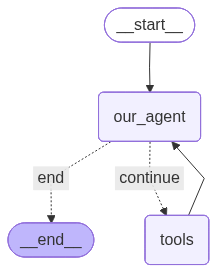

In [ ]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {
    "messages": [
        HumanMessage(content="Add 40 and 12 and then multiply the result by 6.")
    ]
}
result = app.invoke(inputs)

# Extract the final AI response message
final_answer = result["messages"][-1].content

print(final_answer)


The result of the operations is 52 * 6 = 312
